In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## Prepare data

In [3]:
red_train = pd.read_csv("data/winequality-red_train.csv")
white_train = pd.read_csv("data/winequality-white_train.csv")
red_goal = pd.read_csv("data/winequality-red_goal.csv")
white_goal = pd.read_csv("data/winequality-white_goal.csv")

red_goal.drop(columns='quality', inplace=True)
white_goal.drop(columns='quality', inplace=True)

#combine training data for simpler training
#red(0) white(1)
red_train_c = red_train.copy()
red_train_c['color'] = 0
white_train_c = white_train.copy()
white_train_c['color'] = 1
df = pd.concat([red_train_c, white_train_c], ignore_index=True)
df.drop(columns='color', inplace=True) #By feature importance
df['quality'] = df['quality'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5198 non-null   float64
 1   volatile acidity      5198 non-null   float64
 2   citric acid           5198 non-null   float64
 3   residual sugar        5198 non-null   float64
 4   chlorides             5198 non-null   float64
 5   free sulfur dioxide   5198 non-null   float64
 6   total sulfur dioxide  5198 non-null   float64
 7   density               5198 non-null   float64
 8   pH                    5198 non-null   float64
 9   sulphates             5198 non-null   float64
 10  alcohol               5198 non-null   float64
 11  quality               5198 non-null   float64
dtypes: float64(12)
memory usage: 487.4 KB


## Training

In [4]:
# 1. 資料前處理
# 取出特徵 (除去 'quality') 與目標變數
X = df.drop("quality", axis=1).values  # shape = (5198, 11)
y = df["quality"].values               # shape = (5198,)

# 建議使用 StandardScaler 對特徵做標準化，有助於模型收斂
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 將資料轉換成 PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
# 將 y 轉換為 float tensor 並改為 column vector (n_samples, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# 切分訓練與驗證集（例如 80% 訓練、20% 驗證）
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 建立 TensorDataset 與 DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# 2. 定義神經網路模型
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # 回歸預測單一數值
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 設定模型參數，這裡 input_dim 為 11，hidden_dim 可自行調整
input_dim = X_train.shape[1]
hidden_dim = 64
model = SimpleNN(input_dim, hidden_dim)

# 設定運算設備（若有 GPU 則使用 GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SimpleNN(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
# 3. 定義損失函數與優化器
criterion = nn.MSELoss()  # 回歸常用 MSELoss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. 訓練與驗證迴圈
num_epochs = 100

for epoch in range(num_epochs):
    # 訓練階段
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # 移至運算設備
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()      # 清除梯度
        outputs = model(batch_X)   # 前向傳播
        loss = criterion(outputs, batch_y)
        loss.backward()            # 反向傳播
        optimizer.step()           # 更新權重
        
        train_loss += loss.item() * batch_X.size(0)  # 累加損失

    train_loss /= len(train_dataset)
    
    # 驗證階段
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            outputs = model(val_X)
            loss = criterion(outputs, val_y)
            val_loss += loss.item() * val_X.size(0)
    val_loss /= len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/100], Train Loss: 4.2360, Validation Loss: 1.0577
Epoch [2/100], Train Loss: 0.7853, Validation Loss: 0.7032
Epoch [3/100], Train Loss: 0.6036, Validation Loss: 0.6207
Epoch [4/100], Train Loss: 0.5742, Validation Loss: 0.5823
Epoch [5/100], Train Loss: 0.5685, Validation Loss: 0.5976
Epoch [6/100], Train Loss: 0.5527, Validation Loss: 0.5894
Epoch [7/100], Train Loss: 0.5630, Validation Loss: 0.5944
Epoch [8/100], Train Loss: 0.5308, Validation Loss: 0.5729
Epoch [9/100], Train Loss: 0.5387, Validation Loss: 0.6674
Epoch [10/100], Train Loss: 0.5363, Validation Loss: 0.5986
Epoch [11/100], Train Loss: 0.5273, Validation Loss: 0.6042
Epoch [12/100], Train Loss: 0.5412, Validation Loss: 0.6345
Epoch [13/100], Train Loss: 0.5372, Validation Loss: 0.6250
Epoch [14/100], Train Loss: 0.5324, Validation Loss: 0.5913
Epoch [15/100], Train Loss: 0.5229, Validation Loss: 0.6823
Epoch [16/100], Train Loss: 0.5365, Validation Loss: 0.6348
Epoch [17/100], Train Loss: 0.5249, Validation Lo

In [7]:
model.eval()
with torch.no_grad():
    # --- red_goal 評估 ---
    # (1) 使用與訓練時相同的 scaler 對資料做標準化（注意順序要與訓練特徵相同）
    red_goal_scaled = scaler.transform(red_goal.values)
    # (2) 轉換為 tensor 並移至同一個運算設備
    red_goal_tensor = torch.tensor(red_goal_scaled, dtype=torch.float32).to(device)
    # (3) 模型預測，得到連續型的 quality 預測（形狀為 (N, 1)）
    pred_red = model(red_goal_tensor)
    # (4) 移回 CPU 轉換 NumPy 陣列，並 squeeze 多餘的維度
    pred_red = pred_red.cpu().numpy().squeeze()

    # --- white_goal 評估 ---
    white_goal_scaled = scaler.transform(white_goal.values)
    white_goal_tensor = torch.tensor(white_goal_scaled, dtype=torch.float32).to(device)
    pred_white = model(white_goal_tensor)
    pred_white = pred_white.cpu().numpy().squeeze()

# ----------------------------------------
# 後處理預測結果：取整數（這裡假設 wine quality 為整數）
# 若預測出來是 5.8 會轉換為 6
red_goal['quality'] = np.round(pred_red).astype(int)
white_goal['quality'] = np.round(pred_white).astype(int)

# ----------------------------------------
# 製作 ID 欄位
red_goal['ID'] = ['red_' + str(i + 1) for i in range(len(red_goal))]
white_goal['ID'] = ['white_' + str(i + 1) for i in range(len(white_goal))]

# 取出最終要輸出的欄位
r_final = red_goal[['ID', 'quality']]
w_final = white_goal[['ID', 'quality']]

# 合併紅、白預測結果
combined_df = pd.concat([r_final, w_final], ignore_index=True)

# 儲存為 CSV
combined_df.to_csv("combined_predictions.csv", index=False)
print("預測結果已儲存至 combined_predictions.csv")

預測結果已儲存至 combined_predictions.csv


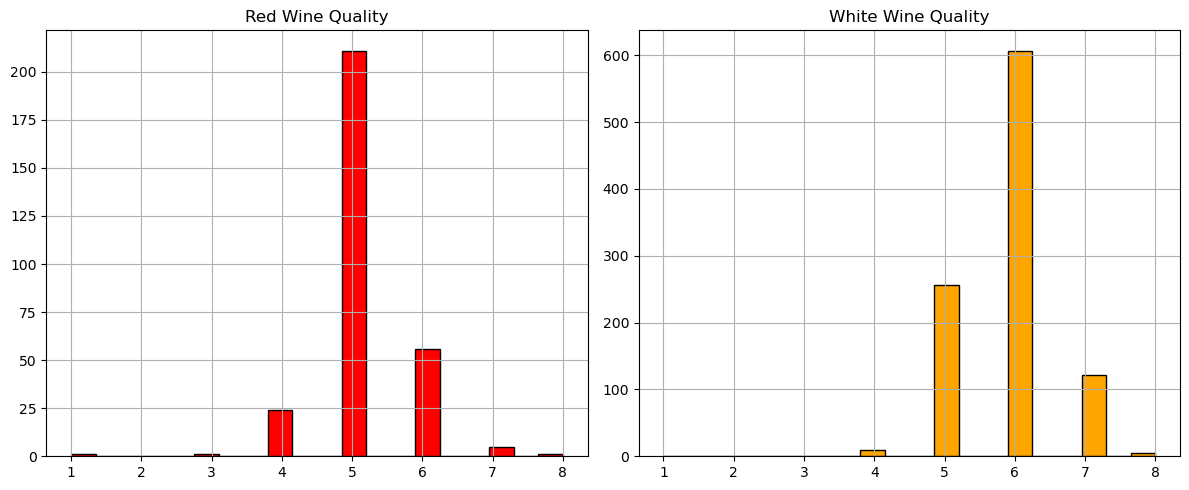

In [8]:
# ----------------------------------------
# 畫出預測 quality 分佈的直方圖
import matplotlib.pyplot as plt

# 如果想要分別看紅白的品質分佈，可以先分別繪圖再合併
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
r_final['quality'].hist(ax=axes[0], bins=20, color='red', edgecolor='black')
axes[0].set_title("Red Wine Quality")
w_final['quality'].hist(ax=axes[1], bins=20, color='orange', edgecolor='black')
axes[1].set_title("White Wine Quality")
plt.tight_layout()
plt.show()